## _Evaluation Metrics_

_If the **GNNBuilder** callback has been run during training, just load data from `run/edge_labelling/test`. Extract `scores ~ y_score` and `y_pid ~ y_truth` to compute model evaluation metrics_.

In [1]:
import sys, os, glob, yaml

In [2]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import torchmetrics
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [5]:
import logging
from collections import namedtuple
import atlasify as atl
from atlasify import atlasify
import sklearn.metrics

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# append parent dir
sys.path.append("..")

In [8]:
from src.metric_utils import compute_metrics, plot_metrics
from src.metric_utils import (
    plot_roc,
    plot_prc,
    plot_prc_thr,
    plot_epc,
    plot_epc_cut,
    plot_output,
)

- _HEP Style Plotting (Histograms, Badges, etc)_

In [9]:
#!pip install mplhep
#!pip install plothist
#!pip install atlasify

### _Evaluation Definitions_

Metrics to evaluate the GNN networks:

- _Accuracy/ACC = $TP+TN/TP+TN+FP+FN$_
- _Sensitivity/Recall/Hit Rate/True Negative Rate ($TPR = 1 - FNR$)_
- _Specificity/Selectivity/True Negative Rate ($TNR = 1 - FPR$)_
- _Miss Rate/False Positive Rate ($FNR = 1 - TPR$)_
- _Fall-out/False Positive Rate ($FPR = 1 - TNR$)_
- _F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$_

Defining Efficiency and Purity:

- _Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$_
- _Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$_

Different ROC Curves:

- _AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot_
- _AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot_


Use _`tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()`_ to directly access TN, FP, FN and TP using `Scikit-learn`.

### _Scikit-learn Nomenclature_

_Each event is a `PyG::Data` object containing useful files. What we need for model evaluation are `edge_index` (**edge list**), `y` or `y_pid` (**true edge labels**), and `scores` (**edge scores/probabilities**) from the `test/pred` dataset. Note that `scores` has twice the lenght of `y_pid` due to flipping operation duing training to create bidirectional edge list. One need to cut it into half._

- _Get **y_true** (or `edge_labels`) as `y` or `y_pid`_
- _Get **y_score** (or `edge_scores`) as `scores`_
- _Get **y_pred** (or `edge_pred`) as `y_pred = scores > 0.5`_

_**Note:** `scores` are raw scores or probabilities of a classifier. Some meterics need raw scores (`y_score`) and others predicted class labels (`y_pred = (y_score > 0.5)`._

### _Load Dataset_

In [10]:
def process_test_files(inputdir, device="cpu"):
    """Add description...."""

    start_time = time.perf_counter()
    test_files = sorted(glob.glob(os.path.join(inputdir, "*")))

    edge_labels, edge_scores = [], []

    # creates iterator yielding (index, value) pair with index starting at 1 instead of the default 0
    for idx, file_path in enumerate(test_files, 1):
        graph = torch.load(file_path, map_location=device)

        e_labels = graph.y_pid
        e_scores = graph.scores[: e_labels.size(0)]

        if idx % 5000 == 0:
            print(f"Processed Batches: {idx}")

        edge_labels.append(e_labels)
        edge_scores.append(e_scores)

    # concatenate torch list
    edge_labels = torch.cat(edge_labels)
    edge_scores = torch.cat(edge_scores)

    end_time = time.perf_counter()
    print(
        f"\nExecution Time: Took {end_time - start_time:.4f} seconds to process {len(test_files)} files."
    )

    return edge_scores, edge_labels

In [11]:
# Experiment Badge
muon_badge = "Simulated: $\mu^\pm$ Pairs, Momentum: 100 MeV/c - 1.5 GeV/c"  # Muons, Badge Subtext
fwp_badge = r"Simulated: $\bar{p}p \rightarrow \bar{\Lambda} \: (\bar{p}\pi^{+}) \: \Lambda \:  (p\pi^{-})$, Beam Momentum = 1.642 GeV/c"  # FWP, Badge Subtext

In [12]:
# DNN (Muons)
inputdir = "run_all/dnn_processed_ln/pred"
outname = "dnn"
c_label = "FCN"
badgetext = muon_badge

# GNN (Muons)
inputdir = "run_all/gnn_processed/pred"
outname = "gnn"
c_label = "IGNN"
badgetext = muon_badge

# GNN (FWP + No Filtering)
inputdir = "run_all/fwp_gnn_processed/pred"
outname = "fwp"
c_label = "IGNN"
badgetext = fwp_badge

- _view an event_

In [13]:
test_files = sorted(glob.glob(os.path.join(inputdir, "*")))
print("Number of Files: ", len(test_files))

Number of Files:  29703


In [14]:
# Let's test a event
data = torch.load(test_files[0], map_location=device)

In [15]:
data

Data(x=[24, 3], pid=[24], layers=[24], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000000000', hid=[24], pt=[24], vertex=[24, 3], charge=[24], pdgcode=[24], ptheta=[24], peta=[24], pphi=[24], modulewise_true_edges=[2, 22], layerwise_true_edges=[2, 25], edge_index=[2, 44], y_pid=[44], scores=[88])

- _fetch all events_

In [16]:
# get edge_scores and edge_labels from all events
# edge_scores, edge_labels = process_test_files(inputdir, device)

- _covert `torch` tensors to `numpy` arrays_

In [17]:
# edge_scores, edge_labels = edge_scores.numpy(), edge_labels.numpy()

- _save `edge_scores` and `edge_labels` as `npz` or `pickle` format_

In [18]:
# np.savez(outname+"_scores_labels.npz", edge_scores=edge_scores, edge_labels=edge_labels)

- _load `edge_scores` and `edge_labels` from `npz` or `pickle` format_

In [19]:
# load npz data
data = np.load(outname + "_scores_labels.npz")

# extract npz data
edge_scores, edge_labels = data["edge_scores"], data["edge_labels"]

### _Compute Metrics_

- load _`scores`_ and _`truths`_ if saved already, otherwise run comments these lines and run from top.

In [20]:
metrics = compute_metrics(edge_scores, edge_labels, threshold=0.5)

### _(a) - Plot Metrics_

In [21]:
# Plot Metrics
# plot_metrics(edge_scores, edge_labels, metrics, name=outname)

In [22]:
# ROC Curve
# plot_roc(metrics, name=outname)

In [23]:
# PR Curve
# plot_prc(metrics, name=outname)

In [24]:
# Built from PRC Curve
# plot_prc_thr(metrics, name=outname)

In [25]:
# EP Curve from ROC
# plot_epc(metrics, name=outname)

In [26]:
# Built from ROC Curve
# plot_epc_cut(metrics, name=outname)

In [27]:
# Model output: True and False
# plot_output(scores, truths, threshold=0.5, name=outname)

### _(a) - Plot Metrics (New)_

- _New Plots with Experiment Badge (Slight different fuctions as in `src/metrics_utils.py`)_

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl

mpl.rcParams["lines.linewidth"] = 2

In [29]:
figsize = (7, 6)

- _**EPC Curve**: Plott Efficiency (x) vs Purity (y)_

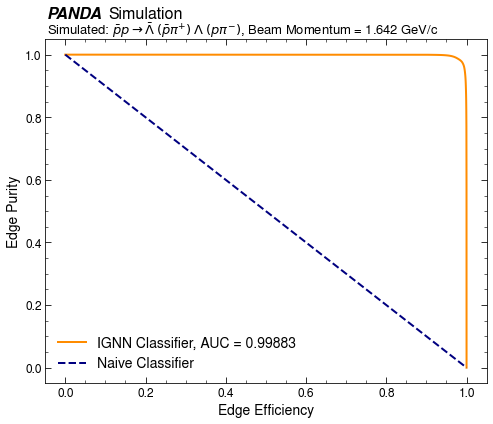

In [30]:
plt.close("all")

# Efficiency, Purity
eff = metrics.roc_tpr
pur = 1 - metrics.roc_fpr
epc_auc = sklearn.metrics.auc(eff, pur)

# Plotting
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)
axs.plot(
    eff, pur, color="darkorange", label=f"{c_label} Classifier, AUC = {epc_auc:.5f}"
)
axs.plot([0, 1], [1, 0], color="navy", linestyle="--", label=f"Naive Classifier")

# Axes Params
# axs.set_title("EP Curve, AUC = %.5f" % epc_auc, fontsize=15)
axs.set_xlabel("Edge Efficiency", fontsize=14)
axs.set_ylabel("Edge Purity", fontsize=14)
axs.tick_params(axis="both", which="major", labelsize=12)
axs.tick_params(axis="both", which="minor", labelsize=12)
axs.legend(loc="lower left", fontsize=14)

# Fig Badge (ATLAS, BELLE II, PANDA, etc)
# atl.ATLAS = "PANDA"
# atl.monkeypatch_axis_labels()
atl.atlasify(
    "Simulation",
    badgetext,  # Subtext
    font_size=16,  # Main Badge
    label_font_size=16,  # Text After Badge
    sub_font_size=13,  # Subtext
    subtext_distance=0.0,
    brand="PANDA",
    # enlarge=1.2,
    outside=True,
)

# Fig Params
fig.tight_layout()
fig.savefig(f"{outname}_epc.pdf", dpi=300)

- _**EPC Curve**: Plott Edge Score (x) vs Efficiency & Purity (y)_

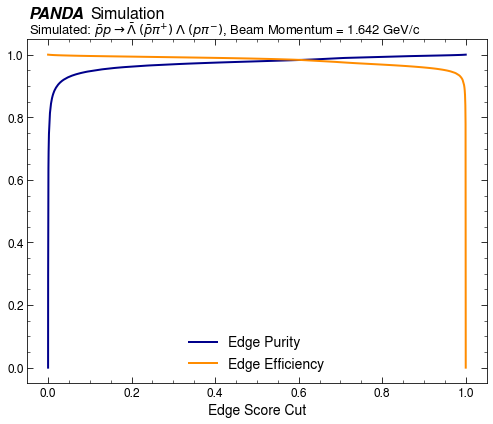

In [31]:
plt.close("all")

# Efficiency, Purity and Threshold
eff = metrics.roc_tpr
pur = 1 - metrics.roc_fpr
score_cuts = metrics.roc_thresh

# Make sure this is nicely plottable!
eff, pur, score_cuts = (
    eff[score_cuts <= 1],
    pur[score_cuts <= 1],
    score_cuts[score_cuts <= 1],
)

# Plotting
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)
axs.plot(score_cuts, pur, color="darkblue", label="Edge Purity")  # Purity
axs.plot(score_cuts, eff, color="darkorange", label="Edge Efficiency")  # Efficiency

# Axes Params
# axs.set_title("Edge Scores vs Efficiency and Purity", fontsize=15)
axs.set_xlabel("Edge Score Cut", fontsize=14)
axs.tick_params(axis="both", which="major", labelsize=12)
axs.tick_params(axis="both", which="minor", labelsize=12)
# axs.set_ylim(0.5,1.02)
axs.legend(loc="lower center", fontsize=14)

# Fig Badge (ATLAS, BELLE II, PANDA, etc)
# atl.ATLAS = "PANDA"
# atl.monkeypatch_axis_labels()
atl.atlasify(
    "Simulation",
    badgetext,  # Subtext
    font_size=16,  # Main Badge
    label_font_size=16,  # Text After Badge
    sub_font_size=13,  # Subtext
    subtext_distance=0.0,
    brand="PANDA",
    outside=True,
)

# Fig Params
fig.tight_layout()
fig.savefig(f"{outname}_epc_cut.pdf", dpi=300)

- **Model Output**

In [32]:
y_pred = edge_scores > 0.5

In [33]:
y_pred[:5]

array([ True, False, False,  True, False])

In [34]:
# plot_output(preds, targets, threshold=0.5, name="gnn")
# plot_output(scores, truths, threshold=0.5, name=outname)

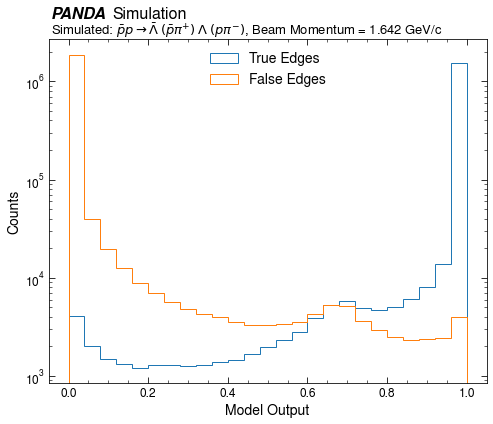

In [35]:
plt.close("all")

# Prepare the values
y_true = edge_labels > 0.5  # this not required at all

# Figure & Axes
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)

# Ploting
binning = dict(bins=25, range=(0, 1), histtype="step", lw=1, log=True)
axs.hist(edge_scores[y_true == True], label="True Edges", **binning)  # True Edges
axs.hist(edge_scores[y_true == False], label="False Edges", **binning)  # False Edges

# Axes Params
# axs.set_title("Classifier Output", fontsize=15)
axs.set_xlabel("Model Output", size=14)
axs.set_ylabel("Counts", size=14)
axs.tick_params(axis="both", which="major", labelsize=12)
axs.tick_params(axis="both", which="minor", labelsize=12)
# axs.set_ylim(ymin=.005)
axs.legend(loc="upper center", fontsize=14)

# Fig Badge (ATLAS, BELLE II, PANDA, etc)
# atl.ATLAS = "PANDA"
# atl.monkeypatch_axis_labels()
atl.atlasify(
    "Simulation",
    badgetext,  # Subtext
    font_size=16,  # Main Badge
    label_font_size=16,  # Text After Badge
    sub_font_size=13,  # Subtext
    subtext_distance=0.0,  # Distance before subtext
    brand="PANDA",  # Change defaults to PANDA
    outside=True,  # Inside or Outside
)

# Fig Params
fig.tight_layout()
fig.savefig(f"{outname}_outputs.pdf", dpi=300)

- Note that in all of above metrics not cut is applied on edge_scores.

### _(b) - S/B Suppression_

Background rejection rate (1/FPR) is given as $1/\epsilon_{bkg}$ where $\epsilon_{bkg}$ is the fraction of fake edges that pass the classification requirement. Signal efficiency (TPR ~ Recall) ($\epsilon_{sig}$) is defined as the number of true edges above a given classification score cut over the total number of true edges. What we have?

- Signal Efficiency = $\epsilon_{sig}$ = TPR ~ Recall 
- Background Rejection = $1 - \epsilon_{bkg}$ ???
- Background Rejection Rate = $1/\epsilon_{bkg}$ = 1/FPR


First apply a edge score cut to binarized the `scores`, we will call it `preds`. The count number of false or true edges that pass this cut. Then calculated background rejection rate and signal efficiency. For making a plot one can do calculations in batch by batch mode on the test dataset.

In [36]:
from sklearn.metrics import confusion_matrix

- _TPR/Recall and FPR from Confusion Matrix (it needs `y_pred` and `y_true` thus need a `threshold ~ 0.5` on `y_score`)_

In [37]:
threshold = 0.5
y_pred, y_true = (edge_scores > threshold), (edge_labels > threshold)

In [38]:
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Find Recal/TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

In [39]:
# TPR and FPR
tpr, fpr

(0.9871353249141622, 0.02133736683225086)

- **_edge efficiency vs edge purity_**

In [40]:
# edge efficiency (TPR), purity (1 - FPR)
print("edge efficiency: {:.4f}\n    edge purity: {:.4f}".format(tpr, (1 - fpr)))

edge efficiency: 0.9871
    edge purity: 0.9787


- **_signal vs background rejection rate_**

In [41]:
# Signal efficiency (TPR), Bkg efficiency (FPR), Bkg Rejection (1/FPR)
print(
    "     Signal efficiency: {:.4f}\nMisidentification rate: {:.4f}\n  Bkg rejection factor: {:.4f}".format(
        tpr, fpr, (1 / fpr)
    )
)

     Signal efficiency: 0.9871
Misidentification rate: 0.0213
  Bkg rejection factor: 46.8661


- _Get signal efficiency (TPR/Recall) for all thresholds, so we need ROC TPR and ROC TPR_

In [42]:
# Signal Efficiency
sig = metrics.roc_tpr

In [43]:
# Background Rejection Factor (BRF)

# handle divided by zero, replace zeros with small +ve value
# bkg_rejection = 1/metrics.roc_fpr
bkg_rejection = 1 / np.where(metrics.roc_fpr == 0, 1e-10, metrics.roc_fpr)

In [44]:
# cut off eff < 0.2 or 0.5
sig_mask = sig > 0.6

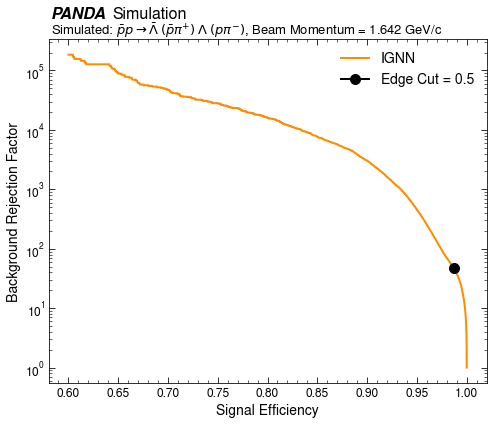

In [45]:
plt.close("all")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

ax.plot(sig[sig_mask], bkg_rejection[sig_mask], color="darkorange", label=f"{c_label}")
ax.plot(
    tpr,
    1 / fpr,
    marker="o",
    markersize=10,
    markeredgecolor="k",
    markerfacecolor="k",
    label=f"Edge Cut = {threshold}",
    color="k",
)

# Axes Params
ax.set_xlabel("Signal Efficiency", fontsize=14)
ax.set_ylabel("Background Rejection Factor", fontsize=14)
ax.set_yscale("log")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.tick_params(axis="both", which="minor", labelsize=12)
ax.legend(fontsize=14, loc="upper right")

# Fig Badge (ATLAS, BELLE II, PANDA, etc)
# atl.ATLAS = "PANDA"
# atl.monkeypatch_axis_labels()
atl.atlasify(
    "Simulation",
    badgetext,  # Subtext
    font_size=16,  # Main Badge
    label_font_size=16,  # Text After Badge
    sub_font_size=13,  # Subtext
    subtext_distance=0.0,
    brand="PANDA",
    outside=True,
)

# Figure Params
fig.tight_layout()
fig.savefig(f"{outname}_SB.pdf", dpi=300)

### _(c) - Visualize Model Output_